In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [27]:
# Load CSV

df = pd.read_csv('Daily Data Receipt Count Prediction.csv')
dfInt = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)# Convert to integers (non-numeric values are coerced to NaN, then filled with 0)
data = dfInt.iloc[:, 1].values.reshape(-1, 1) # Select the second column and reshape to (365, 1)
dataTensor = torch.tensor(data, dtype=torch.float32)

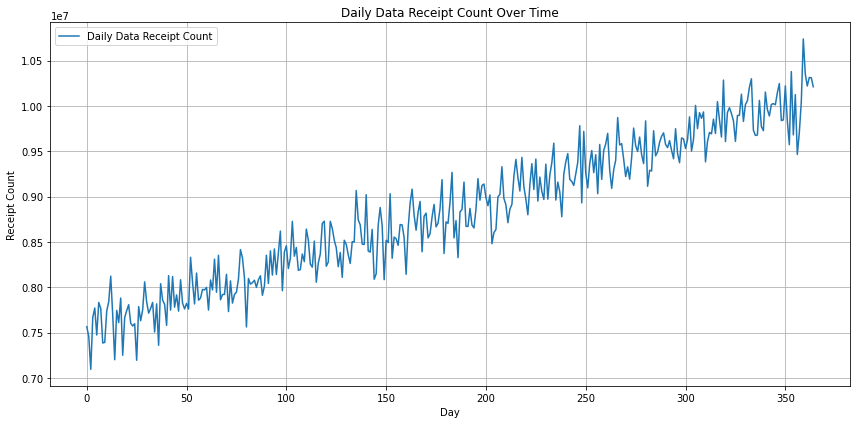

In [28]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(dataTensor, label='Daily Data Receipt Count')
plt.title('Daily Data Receipt Count Over Time')
plt.xlabel('Day')
plt.ylabel('Receipt Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Thoughts about the data

The data clearly looks linear with some noise. I hypothesise that the data is modeled by some simple 


# A Simple Gaussian Conditional Model

### Regression Model:
$$
y = \underbrace{w_0 + w_1 x}_{f(\mathbf{w}, x)} + \epsilon,\quad \epsilon \sim \mathcal{N}(0, 1)
$$


**Input:** $ x \in \mathbb{R} $, **Output:** $ y \in \mathbb{R} $
**Model parameter:** $ \mathbf{w} = [w_0, w_1] $

---

### Conditional probability model:
$$
y \sim \mathcal{N}(f(\mathbf{w}, x), 1)
$$

It only models relationship between $ y $ and $ x $, but does not model the probability distribution of $ x $.

![Gaussian Conditional Model](DummyGaussianConditionalModel.png)

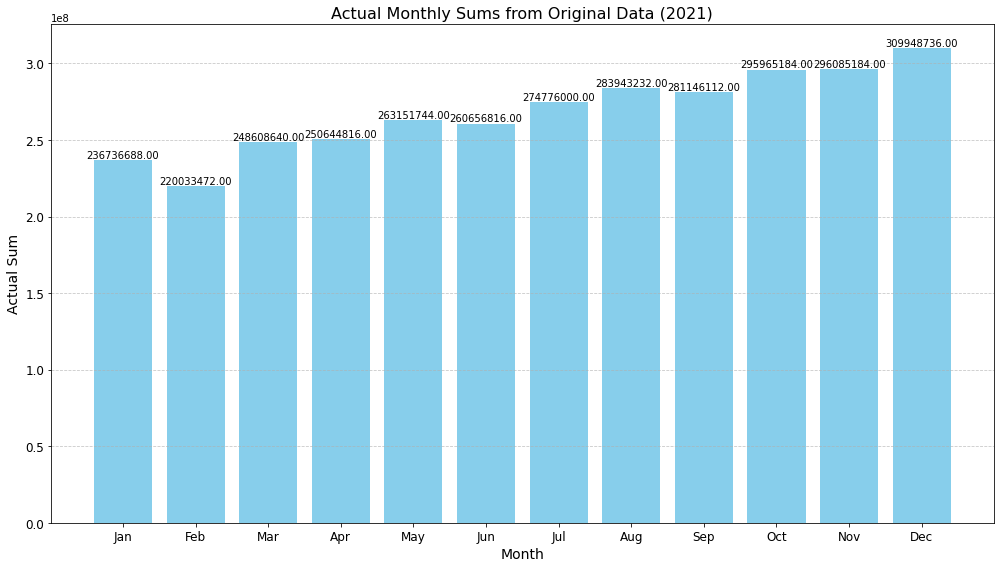

In [29]:
# array of number of days in each month of the year
window = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

original_data = dataTensor.numpy().flatten()

# Compute actual monthly sums from original data
start = 0
monthly_actual_sums = []

for days_in_month in window:
    end = start + days_in_month
    month_sum = np.sum(original_data[start:end])
    monthly_actual_sums.append(month_sum)
    start = end

plt.figure(figsize=(14, 8))
bars = plt.bar(range(1, 13), monthly_actual_sums, color='skyblue')

# Annotate bars with numeric values
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

# Styling
plt.xlabel("Month", fontsize=14)
plt.ylabel("Actual Sum", fontsize=14)
plt.title("Actual Monthly Sums from Original Data (2021)", fontsize=16)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# SIMPLE METHOD: LST SQ REGRESSION

This kind of data usually is best modelled by Least Squares Regression. I havent showed the work for derivation, Maximum Likelihood estimate or Optimization for the least squares here since it is a very basic model, especially when working with python. 

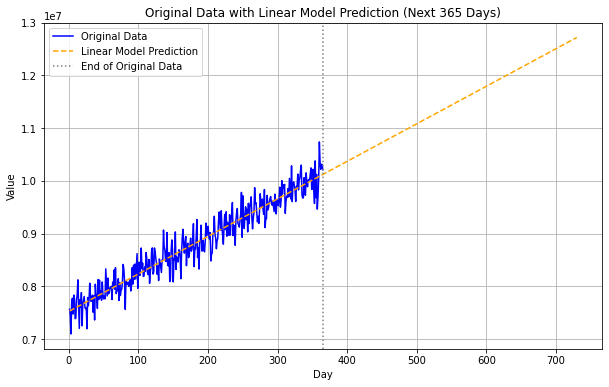

In [30]:
data_np = dataTensor.numpy()

# Prepare design matrix A = [day, 1]
days = np.arange(1, 366).reshape(-1, 1)
ones = np.ones((365, 1))
A = np.hstack((days, ones))  # Shape: (365, 2)

# Least squares linear fit
x, resid, rank, s = np.linalg.lstsq(A, data_np, rcond=None)
m, b = x.flatten()

# Predict from day 1 to 731
extended_days = np.arange(1, 731).reshape(-1, 1)
predicted_values = m * extended_days + b
y = predicted_values[366:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 366), data_np, label="Original Data", color='blue')
plt.plot(extended_days, predicted_values, label="Linear Model Prediction", color='orange', linestyle='--')
plt.axvline(x=365, color='gray', linestyle=':', label="End of Original Data")
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Original Data with Linear Model Prediction (Next 365 Days)")
plt.legend()
plt.grid(True)
plt.show()

sums = []
start = 0
window = 1
while start + window <= len(y):
    chunk = y[start:start + window]
    chunk_sum = np.sum(chunk)
    sums.append(chunk_sum)
    start += window
    window += 1

# 
Seeing that the Least Squares Regression indeed models the data well, I want to now train it only over half the data to compare if the sums of the predicted match the test data. 

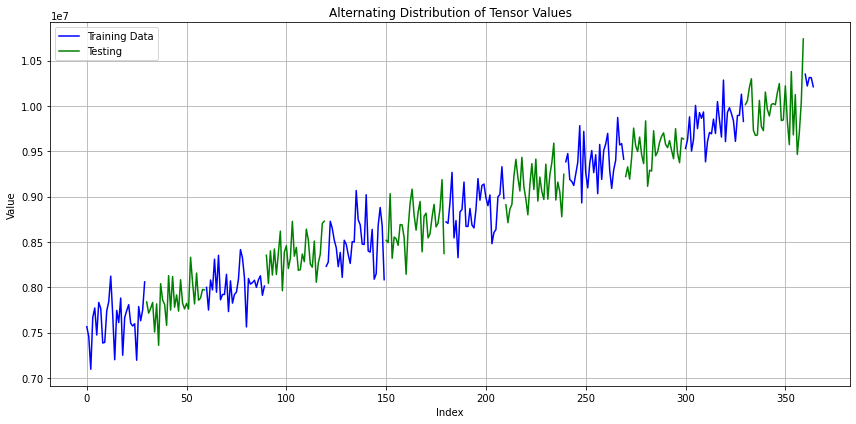

In [31]:
data_np = dataTensor.numpy().flatten()  # Make sure it's 1D

# Create first_array and second_array
first_array = np.full_like(data_np, np.nan, dtype=float)
second_array = np.full_like(data_np, np.nan, dtype=float)
block_size = 30

for i in range(0, len(data_np), block_size):
    if (i // block_size) % 2 == 0:
        first_array[i:i + block_size] = data_np[i:i + block_size]
    else:
        second_array[i:i + block_size] = data_np[i:i + block_size]


# Convert to arrays
first = np.array(first_array)
second = np.array(second_array)
plt.figure(figsize=(12, 6))
plt.plot(first, color='blue', label='Training Data')
plt.plot(second, color='green', label='Testing')
plt.title('Alternating Distribution of Tensor Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
train_mask = ~np.isnan(first_array)  # 1D boolean mask
train_days = np.arange(1, 366)[train_mask].reshape(-1, 1)
train_targets = first_array[train_mask].reshape(-1, 1)

# Design matrix A = [day, 1]
train_ones = np.ones_like(train_days)
A_train = np.hstack((train_days, train_ones))  # Shape: (n_train, 2)

# Least squares linear fit
x, resid, rank, s = np.linalg.lstsq(A_train, train_targets, rcond=None)
m, b = x.flatten()

print("Slope (m):", m)
print("Intercept (b):", b)

Slope (m): 7348.624555703
Intercept (b): 7484849.983335175


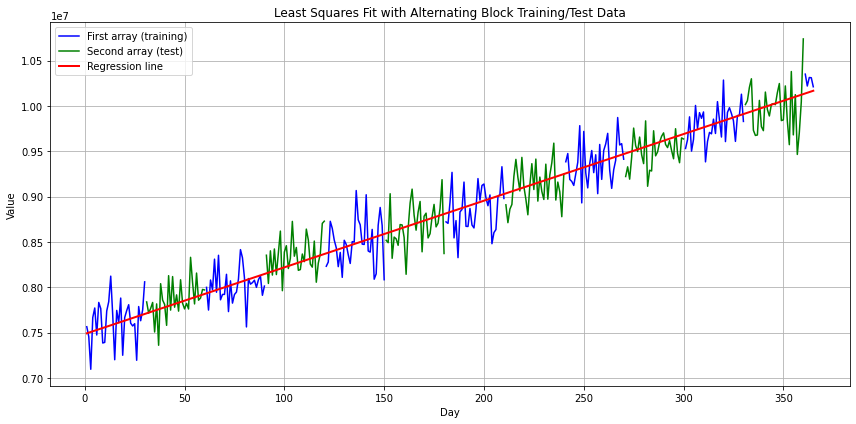

In [33]:
all_days = np.arange(1, 366).reshape(-1, 1)
predicted_line = m * all_days + b

# Plotting
plt.figure(figsize=(12, 6))

# Plot training (first_array) data
plt.plot(all_days, first_array, 'b-', label='First array (training)', markersize=4)

# Plot second_array data
plt.plot(all_days, second_array, 'g-', label='Second array (test)', markersize=4)

# Plot the regression line
plt.plot(all_days, predicted_line, 'r-', label='Regression line', linewidth=2)

# Labels and legend
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Least Squares Fit with Alternating Block Training/Test Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Segment 0: Actual = 235842221.00, Predicted = 234576372.02, Diff = 1265848.98
Segment 1: Actual = 250644830.00, Predicted = 247803896.22, Diff = 2840933.78
Segment 2: Actual = 260453737.00, Predicted = 261031420.42, Diff = -577683.42
Segment 3: Actual = 273516998.00, Predicted = 274258944.62, Diff = -741946.62
Segment 4: Actual = 285167859.00, Predicted = 287486468.82, Diff = -2318609.82
Segment 5: Actual = 299120438.00, Predicted = 300713993.02, Diff = -1593555.02


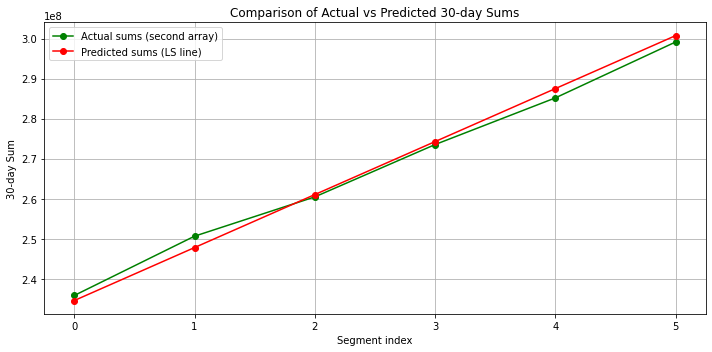

In [34]:
segment_size = 30
num_segments = len(second_array) // segment_size

# Store results
actual_sums = []
predicted_sums = []

for i in range(num_segments):
    start = i * segment_size
    end = start + segment_size

    # Only compute for segments where second_array has real (non-NaN) values
    if not np.isnan(second_array[start:end]).all():
        # Actual sum from second_array
        actual_sum = np.nansum(second_array[start:end])  # nansum just in case
        actual_sums.append(actual_sum)

        # Predict values using the regression line
        days_segment = np.arange(start + 1, end + 1).reshape(-1, 1)
        predicted_segment = m * days_segment + b
        predicted_sum = np.sum(predicted_segment)
        predicted_sums.append(predicted_sum)

# Convert to arrays
actual_sums = np.array(actual_sums)
predicted_sums = np.array(predicted_sums)

# Compare: difference
differences = actual_sums - predicted_sums

# Print results
for i, (act, pred, diff) in enumerate(zip(actual_sums, predicted_sums, differences)):
    print(f"Segment {i}: Actual = {act:.2f}, Predicted = {pred:.2f}, Diff = {diff:.2f}")
    
plt.figure(figsize=(10, 5))
plt.plot(actual_sums, 'go-', label='Actual sums (second array)')
plt.plot(predicted_sums, 'ro-', label='Predicted sums (LS line)')
plt.xlabel("Segment index")
plt.ylabel("30-day Sum")
plt.title("Comparison of Actual vs Predicted 30-day Sums")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Month 1: Predicted sum = 318824954.11
Month 2: Predicted sum = 294040890.18
Month 3: Predicted sum = 332265588.42
Month 4: Predicted sum = 328271335.10
Month 5: Predicted sum = 346161837.46
Month 6: Predicted sum = 341719318.04
Month 7: Predicted sum = 360058086.49
Month 8: Predicted sum = 367120114.69
Month 9: Predicted sum = 362001521.81
Month 10: Predicted sum = 381016363.73
Month 11: Predicted sum = 375449504.75
Month 12: Predicted sum = 394912612.76


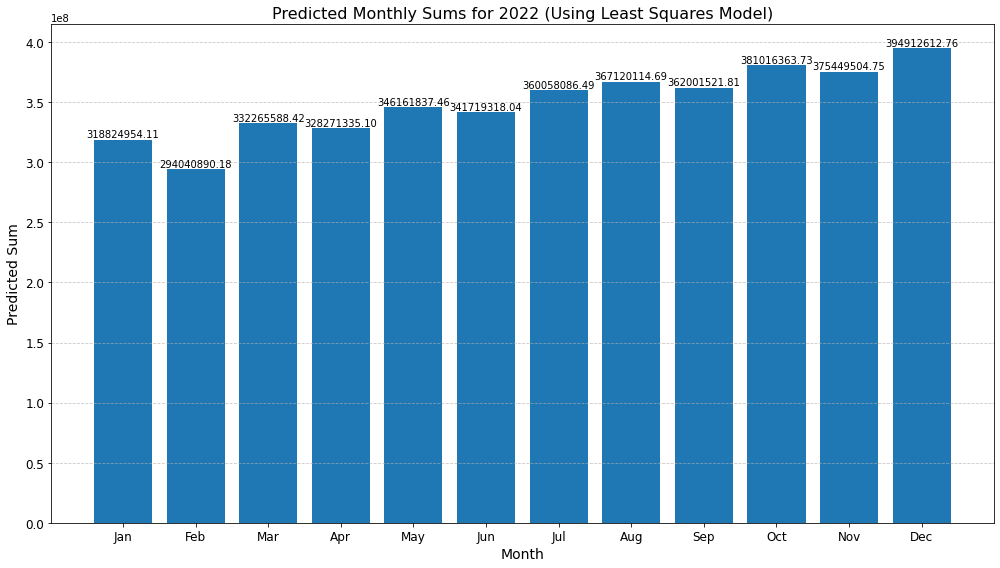

In [10]:
# Predict values for next year (days 366 to 730)
future_days = np.arange(366, 731).reshape(-1, 1)
future_predictions = m * future_days + b

# Define window (month lengths)
window = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Compute sums for each window
start = 0
monthly_predicted_sums = []

for days_in_month in window:
    end = start + days_in_month
    month_sum = np.sum(future_predictions[start:end])
    monthly_predicted_sums.append(month_sum)
    start = end

# Show results
for i, s in enumerate(monthly_predicted_sums):
    print(f"Month {i + 1}: Predicted sum = {s:.2f}")

plt.figure(figsize=(14, 8))
bars = plt.bar(range(1, 13), monthly_predicted_sums)

# Annotate bars with numeric values
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

# Styling
plt.xlabel("Month", fontsize=14)
plt.ylabel("Predicted Sum", fontsize=14)
plt.title("Predicted Monthly Sums for 2022 (Using Least Squares Model)", fontsize=16)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# COMPLEX METHOD: ADAM

The instructions mention that the interview aims to assess my PyTorch and/or TensorFlow skills through this excercise. However, least squares implementation does not well demonstrate those skills. Hence, even though i think that least squares is a simple and elegant solution, i present an alternative solution using the Adaptive Momentum (AdaM) method to demonstrate my knowledge over Machine Learning

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Epoch [1000/10000], Train Loss: 0.0762
Converged!

Test Loss: 0.0806


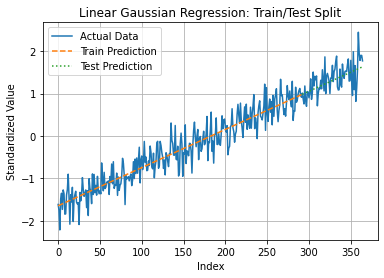

In [12]:

# Standardize: (x - mean) / std
mean = dataTensor.mean()
std = dataTensor.std()
tensor_data = (dataTensor - mean) / std
tensor_data = tensor_data.float()

n = tensor_data.shape[0]
x = torch.arange(n, dtype=torch.float32).view(-1, 1)
y = tensor_data.view(-1, 1)
std2 = tensor_data.std()

# Split into 80% train, 20% test
split_idx = int(0.8 * n)

x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Define a simple linear model
model = nn.Linear(1, 1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.2) #chose a specifically high learning rate because the learning is highly convex with rarely any local minima

# Train the model
num_epochs = 10000
tolerance = 1e-9
prev_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    newLoss = loss.item()
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")
    loss_change = abs(prev_loss - loss.item())
    if loss_change < tolerance:
        print("Converged!")
        break
    prev_loss = loss.item()

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(x_test)
    test_loss = criterion(y_pred_test, y_test)
    print(f"\nTest Loss: {test_loss.item():.4f}")

# Plotting
plt.figure()
plt.plot(x.numpy(), y.numpy(), label="Actual Data")
plt.plot(x_train.numpy(), model(x_train).detach().numpy(), label="Train Prediction", linestyle="--")
plt.plot(x_test.numpy(), y_pred_test.numpy(), label="Test Prediction", linestyle=":")
plt.title("Linear Gaussian Regression: Train/Test Split")
plt.xlabel("Index")
plt.ylabel("Standardized Value")
plt.legend()
plt.grid(True)
plt.show()

Estimated Residual Std Dev (Model Noise): 0.2766


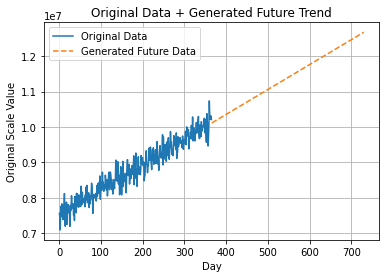

In [13]:
model.eval()
with torch.no_grad():
    train_preds = model(x_train).squeeze()
    residuals = y_train.squeeze() - train_preds

# Step 2: Estimate residual stddev
estimated_std = residuals.std()
print(f"Estimated Residual Std Dev (Model Noise): {estimated_std:.4f}")

# Step 3: Generate future inputs (366 to 730)
x_future = torch.arange(366, 731, dtype=torch.float32).view(-1, 1)  # shape: (365, 1)

# Step 4: Predict future trend
with torch.no_grad():
    predicted_std_data = model(x_future).squeeze()

# Step 5: Add noise using residual std
noise = torch.randn_like(predicted_std_data) * estimated_std
synthetic_data = predicted_std_data * std + mean + noise

plt.figure()
plt.plot(torch.arange(1, len(dataTensor) + 1), dataTensor.numpy(), label="Original Data")
plt.plot(torch.arange(366, 731), synthetic_data.numpy(), label="Generated Future Data", linestyle='--')
plt.title("Original Data + Generated Future Trend")
plt.xlabel("Day")
plt.ylabel("Original Scale Value")
plt.legend()
plt.grid(True)
plt.show()

Month 1: Predicted sum = 316862464.00
Month 2: Predicted sum = 292010496.00
Month 3: Predicted sum = 329732224.00
Month 4: Predicted sum = 325534080.00
Month 5: Predicted sum = 343038176.00
Month 6: Predicted sum = 338410848.00
Month 7: Predicted sum = 356344192.00
Month 8: Predicted sum = 363106240.00
Month 9: Predicted sum = 357831552.00
Month 10: Predicted sum = 376412224.00
Month 11: Predicted sum = 370708256.00
Month 12: Predicted sum = 389718272.00


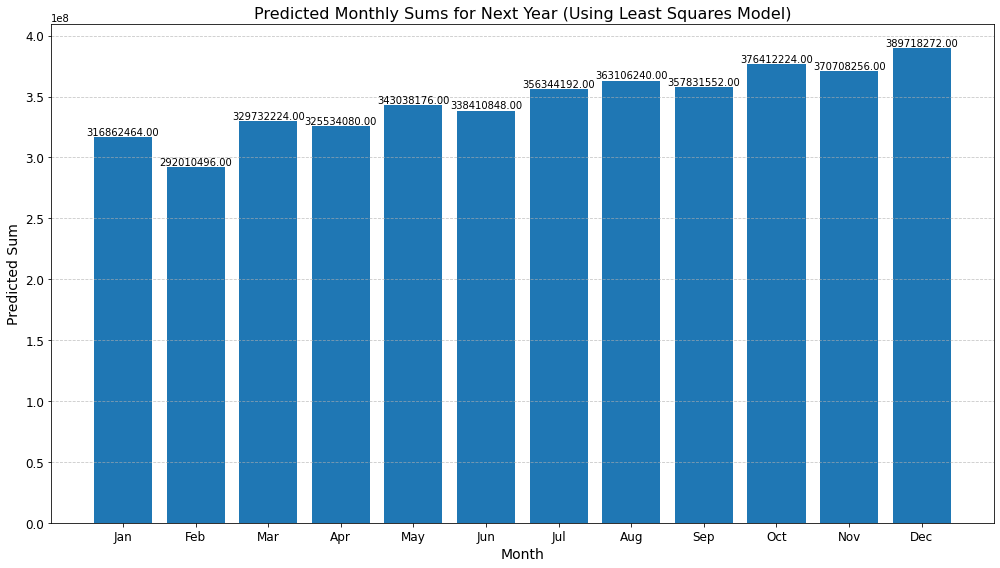

In [14]:
start = 0
monthly_predicted_sums_adam = []
synthetic_data = synthetic_data.numpy()

for days_in_month in window:
    end = start + days_in_month
    month_sum = np.sum(synthetic_data[start:end])
    monthly_predicted_sums_adam.append(month_sum)
    start = end

for i, s in enumerate(monthly_predicted_sums_adam):
    print(f"Month {i + 1}: Predicted sum = {s:.2f}")

plt.figure(figsize=(14, 8))
bars = plt.bar(range(1, 13), monthly_predicted_sums_adam)

# Annotate bars with numeric values
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

# Styling
plt.xlabel("Month", fontsize=14)
plt.ylabel("Predicted Sum", fontsize=14)
plt.title("Predicted Monthly Sums for Next Year (Using Least Squares Model)", fontsize=16)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ANALYSIS OF BOTH METHODS:

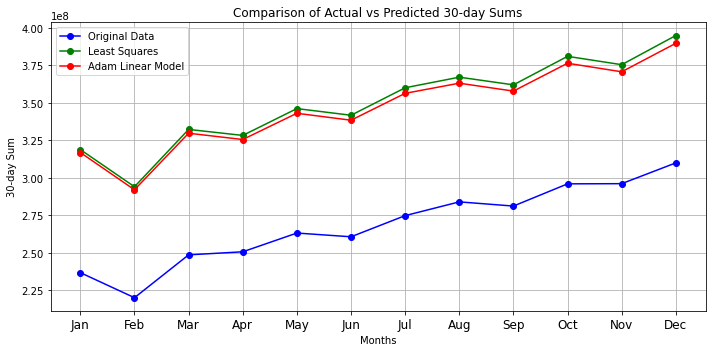

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_actual_sums, 'bo-', label='Original Data')
plt.plot(monthly_predicted_sums, 'go-', label='Least Squares')
plt.plot(monthly_predicted_sums_adam, 'ro-', label='Adam Linear Model')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.xlabel("Months")
plt.ylabel("30-day Sum")
plt.title("Comparison of Actual vs Predicted 30-day Sums")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations and Insights

At first glance, there seems to be **overfitting** in the model.  
This is **partially due to a lack of large data**, but more noticeably, we observe **dips and peaks at exactly the same positions** in both training and test data.

This is primarily because of the **variance in the number of days in each month**.

---

### Additional Factors That May Contribute to Cost Prediction

Here are a few important considerations that i would include given more resources/data:

- **Time of the year**  
  Individuals typically tend to shop more during the end of the year/winter season due to festivals like **Halloween, Thanksgiving, Christmas**, etc.  

- **Growth of the company over the months**  
  As the company grows, it reaches more customers, leading to **more downloads and more receipts scanned per customer**.    

- **Growth of the company over the year**  
  Similar logic applies here.  

- **External economic factors**  
  In 2021, **COVID-19 was at its peak** in the USA. The government provided **stimulus checks (up to $1400)** in April 2021.  
  This resulted in **higher spending** than usual for many households.  
  In contrast, there were **no stimulus checks in 2022**, possibly leading to **lower sales**.